In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
import openpathsampling as paths
import numpy as np
import itertools as itt


def ops_load_trajectory(filename, top=None):
    return paths.engines.openmm.tools.trajectory_from_mdtraj(md.load(filename, top=top))

def min_distance(snapshot, pair):
    import mdtraj as md
    import itertools as itt
    pair_list = list(itt.product(pair[0],pair[1]))
    snapshot = paths.Trajectory(snapshot).md()
    distance = md.compute_distances(snapshot, pair_list)
    result = []
    for i in distance:
        result.append(min(i))
    return result

def COM_distance(snapshot, pair):
    import mdtraj as md
    trj = paths.Trajectory(snapshot).md()
    set0_trj = trj.atom_slice(pair[0])
    set1_trj = trj.atom_slice(pair[1])
    set0_center = md.compute_center_of_mass(set0_trj)
    set1_center = md.compute_center_of_mass(set1_trj)
    distances = set0_center-set1_center
    result = []
    for i in distances:
        result.append(((i[0]**2) + (i[1]**2) + (i[2]**2))**0.5)
    return result

In [ ]:
def main(source='test', run_name='test'):

    if source == 'test':
        current_dir = '/home/sanderroet/scripts/test_show/'
    if source == 'vreede':
        current_dir = '/home/sanderroet/Ras-JV/'+run_name+'/analysis/'
        name = 'vreede_'+run_name
    elif source == 'carbon':
        current_dir = '/home/sanderroet/carbon/kras_100ns/'+run_name+'/analysis/'
        name = 'carbon_'+run_name
    xtc = current_dir + 'vis-md.xtc'
    pdb = current_dir + 'vis-md.pdb'
    
    run = ops_load_trajectory(xtc, top=pdb)
    topology = run.topology.md
    
    gly60 = topology.select('protein and (resSeq 60)')                   
    gly12 = topology.select('protein and (resSeq 12)')                   
    gln61 = topology.select('protein and resSeq 61 and not backbone and not name H')
    arg68 = topology.select('protein and resSeq 68 and name O')          
    met72 = topology.select('protein and resSeq 72 and name H')          
    GTP = topology.select('((resname GTP) and not element H) or element Mg')
    GTP_COM = topology.select('resname GTP or element Mg')
    glu63 = topology.select('protein and (resSeq 63) and name CG')       
    glu62 = topology.select('protein and (resSeq 62) and name CG')       
    switch2_COM = topology.select('protein and(resSeq 61 to 66)')
    
    d_gly60_gly12 = paths.CV_Function("d_gly60_gly12", min_distance, pair = [gly60, gly12], cv_requires_lists = True)
    d_gln61_gly12 = paths.CV_Function("d_gln61_gly12", min_distance, pair = [gln61, gly12], cv_requires_lists = True)
    d_glu62_GTP   = paths.CV_Function("d_glu62_GTP"  , min_distance, pair = [glu62, GTP], cv_requires_lists = True)
    d_glu63_GTP   = paths.CV_Function("d_glu63_GTP"  , min_distance, pair = [glu63, GTP], cv_requires_lists = True)
    d_arg68_met72 = paths.CV_Function("d_arg68_met72", min_distance, pair = [arg68, met72], cv_requires_lists = True)
    d_COM_S2_GTP  = paths.CV_Function("d_COM_S2_GTP" , COM_distance, pair = [GTP_COM, switch2_COM], cv_requires_lists = True)
    
    state_open = (paths.CVRangeVolume(d_gly60_gly12, lambda_min=0.6, lambda_max=5.0) &
                  paths.CVRangeVolume(d_gln61_gly12, lambda_min=0.8, lambda_max=5.0) &
                  paths.CVRangeVolume(d_glu62_GTP, lambda_min=1.0, lambda_max=5.0) &
                  paths.CVRangeVolume(d_glu63_GTP, lambda_min=1.0, lambda_max=5.0) &
                  paths.CVRangeVolume(d_COM_S2_GTP, lambda_min=1.975, lambda_max=5.0)).named('Open')

    state_closed =((paths.CVRangeVolume(d_gly60_gly12, lambda_min=0.0, lambda_max=0.3) |
                   paths.CVRangeVolume(d_gln61_gly12, lambda_min=0.0, lambda_max=0.3) |
                   paths.CVRangeVolume(d_glu62_GTP, lambda_min=0.0, lambda_max=0.6) |
                   paths.CVRangeVolume(d_glu63_GTP, lambda_min=0.0, lambda_max=0.6)) &
                   paths.CVRangeVolume(d_COM_S2_GTP, lambda_min=0.0, lambda_max=1.6)).named('Closed')

    variable_list = [
                     d_gly60_gly12,
                     d_gln61_gly12,
                     d_glu62_GTP,
                     d_glu63_GTP,
                     d_arg68_met72,
                     d_COM_S2_GTP,
                    ]

    for i, e in enumerate(variable_list):
        fig = plt.figure()
        (plot_line,) = plt.plot(e(run), label=e.name+'_'+source+'_'+run_name)
        plt.xlabel('frame number')
        plt.ylabel('distance (nm)')
        plt.legend(handles=[plot_line]);
        fig.close()
    n_frames_open = 0
    n_frames_closed = 0
    n_frames_out = 0
    n_frames_both = 0
    i = 0
    for s in run:
        s_open = False
        s_closed = False
        if state_open(s) == True:
            s_open = True
            #print i
        if state_closed(s) == True:
            s_closed = True
        if s_open == True and s_closed == False:
            n_frames_open += 1
        elif s_open == False and s_closed == True:
            n_frames_closed += 1
        elif s_open == False and s_closed == False:
            n_frames_out += 1
        elif s_open == True and s_closed == True:
            n_frames_both += 1
        i += 1
    n_frames = len(run)
    return(n_frames_open, n_frames_closed, n_frames_out, n_frames_both, n_frames)


vreede run0
Frames in open state:  0/10001
Frames in closed state:  9359/10001
Frames not in a state:  642/10001
Frames in both states:  0/10001

vreede run1
Frames in open state:  0/10001
Frames in closed state:  3515/10001
Frames not in a state:  6486/10001
Frames in both states:  0/10001
2792

vreede run2
Frames in open state:  1/10001
Frames in closed state:  3513/10001
Frames not in a state:  6487/10001
Frames in both states:  0/10001


/home/sanderroet/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


8187
8367
8788
8930
8938
9077
9078
9080
9085
9093
9104
9106
9110
9126
9164
9347
9348
9349
9350
9359
9362
9364
9370
9373
9375
9376
9388
9425
9430
9434
9453
9457
9510
9518
9523
9535
9538
9555
9556
9561
9562
9563
9564
9566
9567
9569
9571
9581
9584
9586
9590
9592
9596
9598
9600
9601
9609
9616
9624
9628
9630
9635
9638
9639
9651
9656
9657
9662
9665
9671
9673
9674
9676
9678
9687
9691
9698
9712
9713
9717
9719
9725
9726
9737
9738
9739
9747
9749
9750
9754
9755
9765
9766
9778
9781
9790
9798
9808
9809
9878
9879
9880
9885
9887
9888
9889
9891
9899
9902
9905
9906
9911
9922
9924
9925
9929
9933
9944
9945
9946
9949
9950
9951
9959

vreede run3
Frames in open state:  124/10001
Frames in closed state:  2201/10001
Frames not in a state:  7676/10001
Frames in both states:  0/10001
4920
4921
4922
5085
5087
5089
5096
5100
5101
5102
5104
5105
5106
5107
5108
5109
5110
5111
5113
5114
5115
5116
5117
5118
5125
5129
5137
5145
5148
5152
5153
5160
5161
5164
5165
5168
5169
5170
5171
5172
5173
5175
5176
5178
5179
5180
5

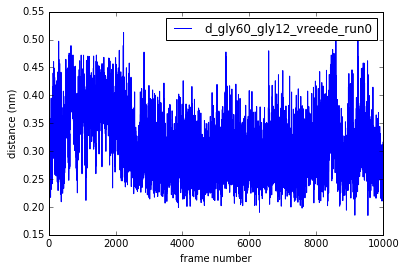

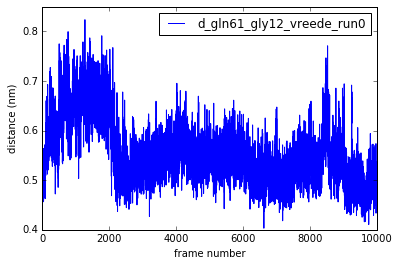

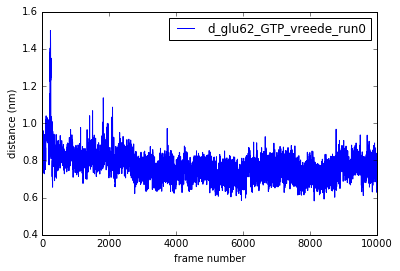

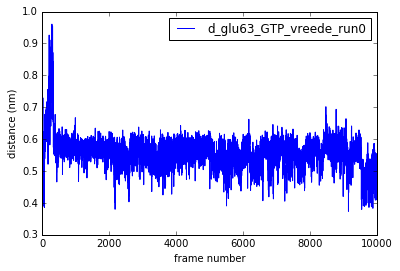

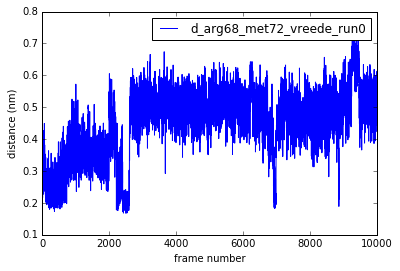

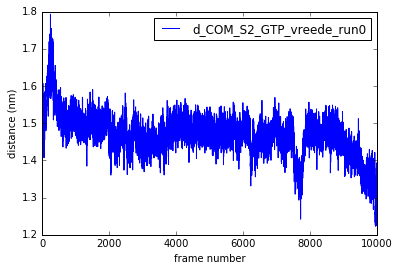

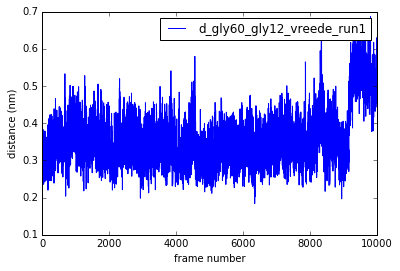

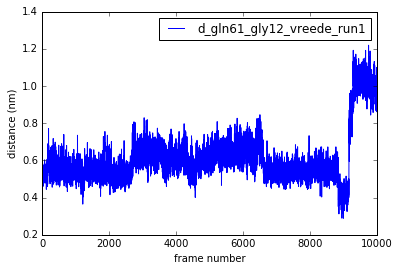

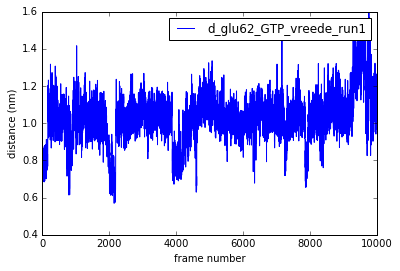

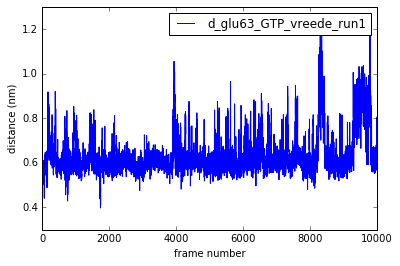

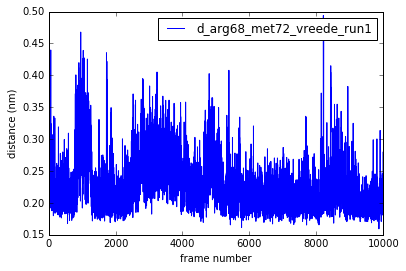

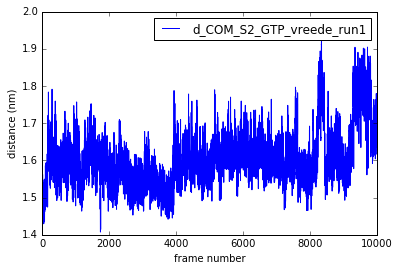

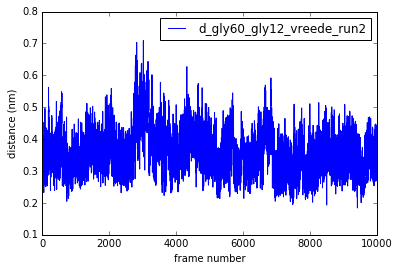

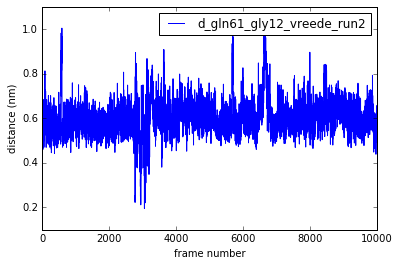

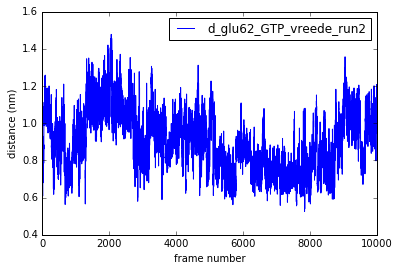

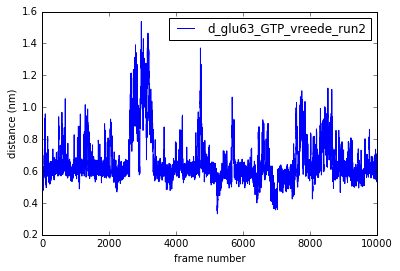

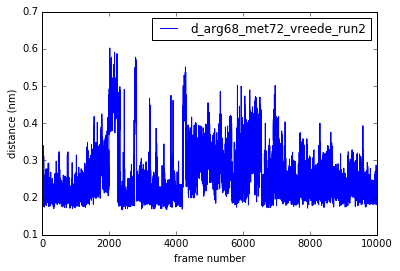

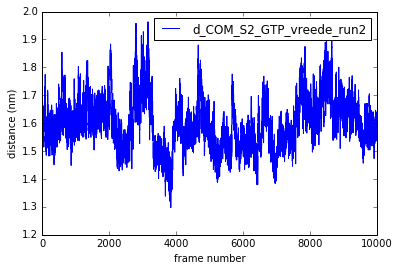

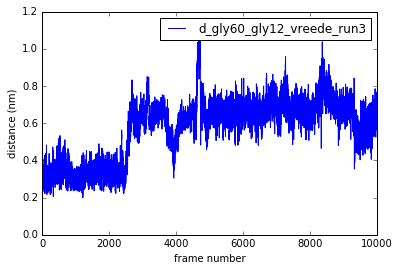

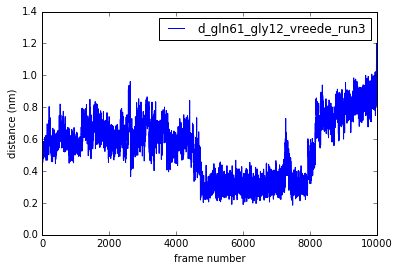

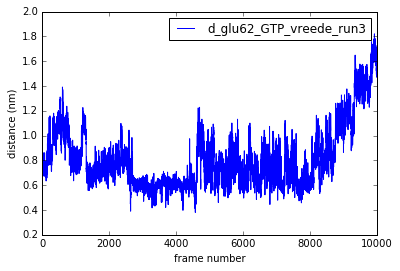

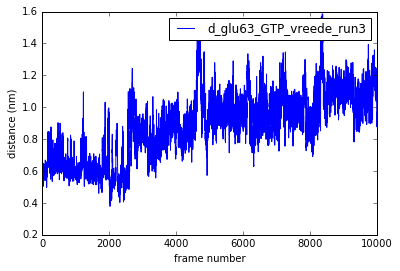

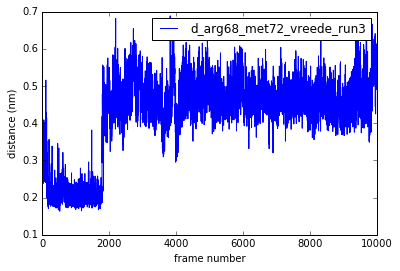

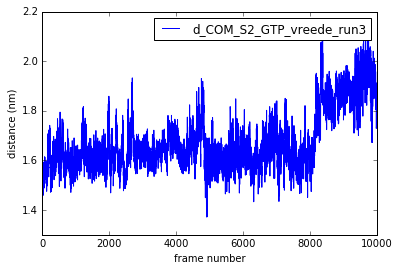

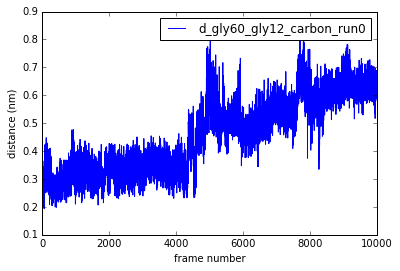

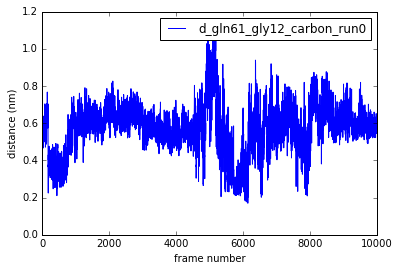

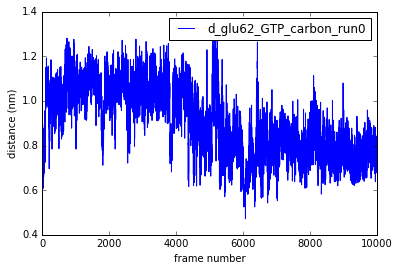

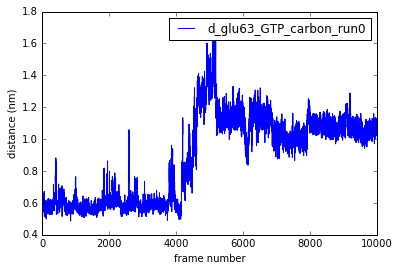

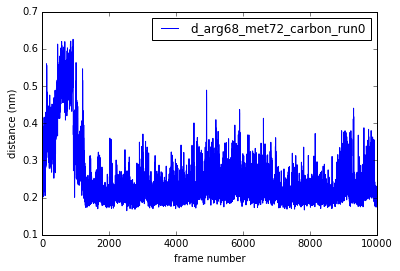

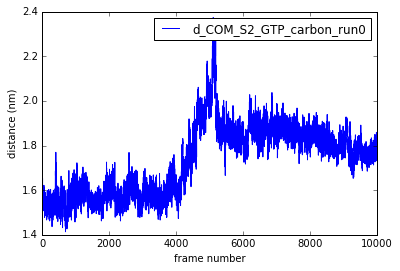

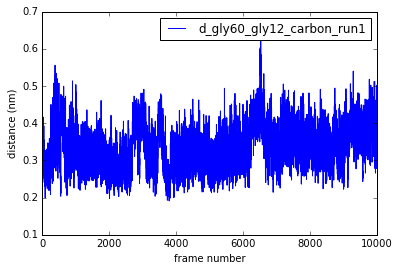

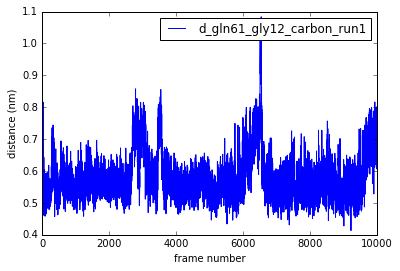

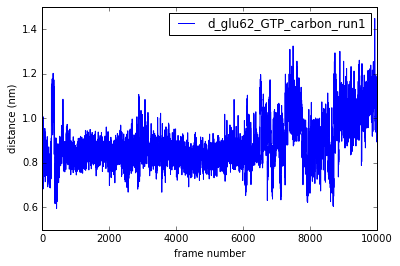

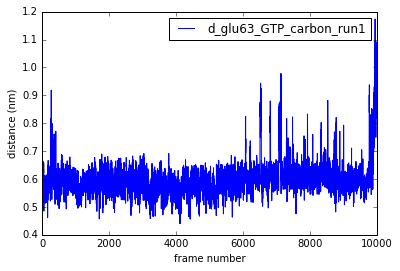

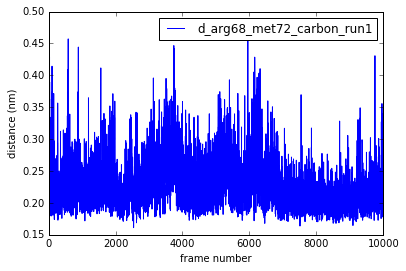

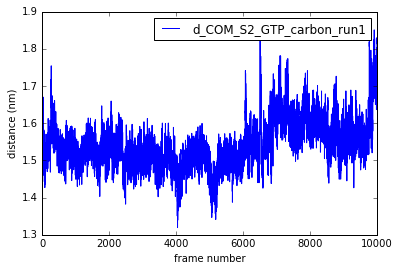

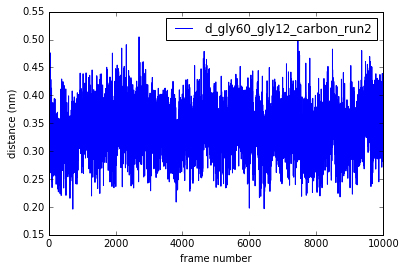

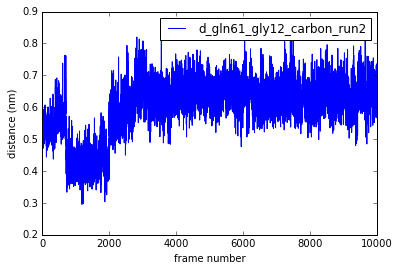

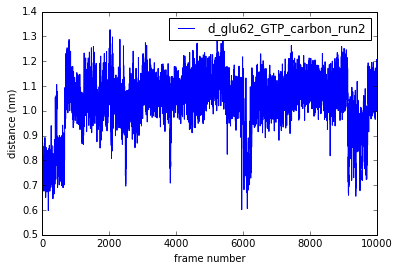

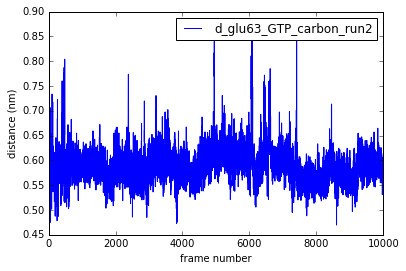

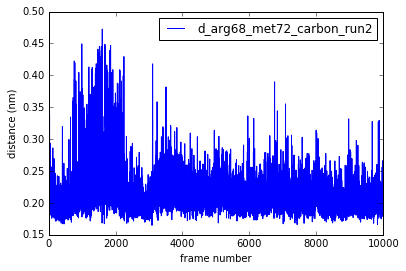

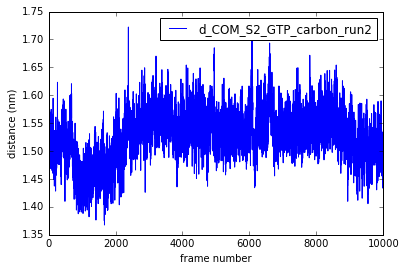

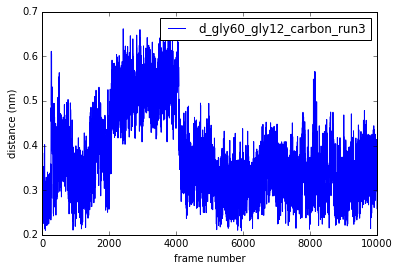

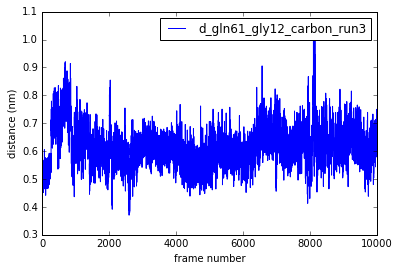

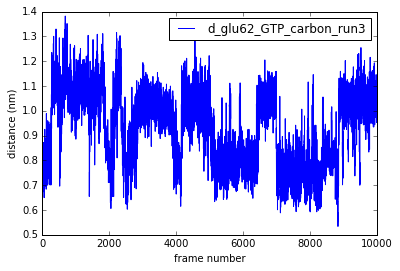

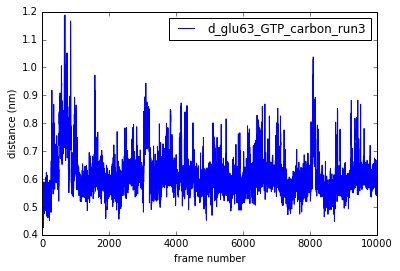

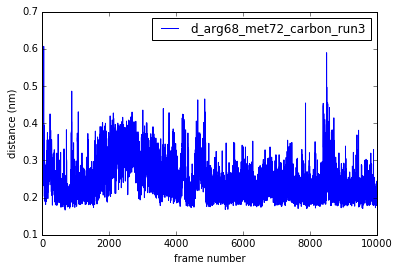

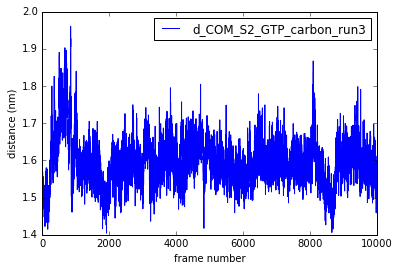

In [ ]:
for i in ['vreede', 'carbon']:
    for j in range(4):
        (n_frames_open, n_frames_closed, n_frames_out, n_frames_both, n_frames) = main(source = i, run_name = 'run'+str(j))
        print "\n"+i+" run"+str(j)
        print "Frames in open state:  " + str(n_frames_open) + "/" + str(n_frames)
        print "Frames in closed state:  " + str(n_frames_closed) + "/" + str(n_frames)
        print "Frames not in a state:  " + str(n_frames_out) + "/" + str(n_frames)
        print "Frames in both states:  " + str(n_frames_both) + "/" + str(n_frames)